<a href="https://colab.research.google.com/github/AlexandraZavala/BrainTumorClasifcation/blob/main/BrainRumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#1. Get the dataset

In [30]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 97% 144M/149M [00:00<00:00, 141MB/s]
100% 149M/149M [00:01<00:00, 150MB/s]


In [31]:
#create a function to iterate for the data
def get_class_paths(path):
  classes=[]
  class_path=[]

  #iterate thorugh directories
  for label in os.listdir(path):
    label_path = os.path.join(path,label)

    #Check if its a directory
    if os.path.isdir(label_path):
      #iterate through images
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        classes.append(label)
        class_path.append(image_path)

  df = pd.DataFrame({
      'Class Path': class_path,
      'Class': classes
  })

  return df

#way to classify all images


In [32]:
tr_df = get_class_paths('/content/Training')

In [33]:
tr_df

,Class Path,Class
0,/content/Training/pituitary/Tr-pi_0375.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_0427.jpg,pituitary
2,/content/Training/pituitary/Tr-pi_0031.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_0715.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_0533.jpg,pituitary
...,...,...
5707,/content/Training/notumor/Tr-no_0569.jpg,notumor
5708,/content/Training/notumor/Tr-no_0019.jpg,notumor
5709,/content/Training/notumor/Tr-no_1254.jpg,notumor
5710,/content/Training/notumor/Tr-no_1359.jpg,notumor


In [34]:
ts_df= get_class_paths("/content/Testing")

In [35]:
ts_df

,Class Path,Class
0,/content/Testing/pituitary/Te-pi_0211.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0024.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0101.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0271.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0264.jpg,pituitary
...,...,...
1306,/content/Testing/notumor/Te-no_0137.jpg,notumor
1307,/content/Testing/notumor/Te-noTr_0004.jpg,notumor
1308,/content/Testing/notumor/Te-no_0216.jpg,notumor
1309,/content/Testing/notumor/Te-no_0221.jpg,notumor


#2. Data Visualization

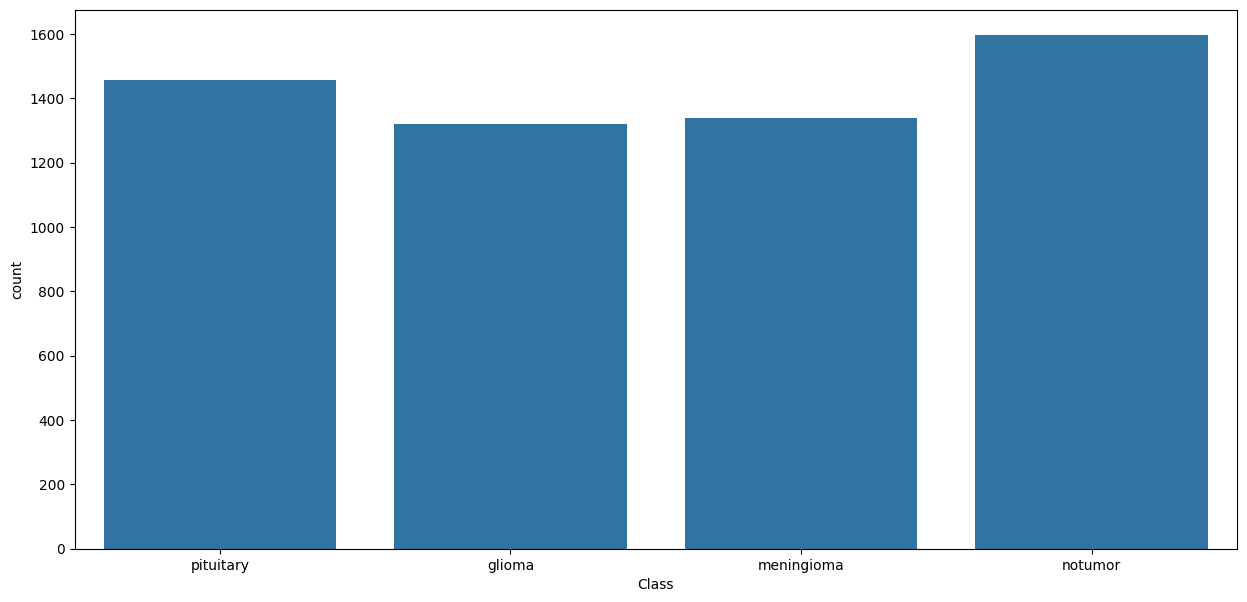

In [36]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, x=tr_df["Class"])

We can see that the dataset is balanced

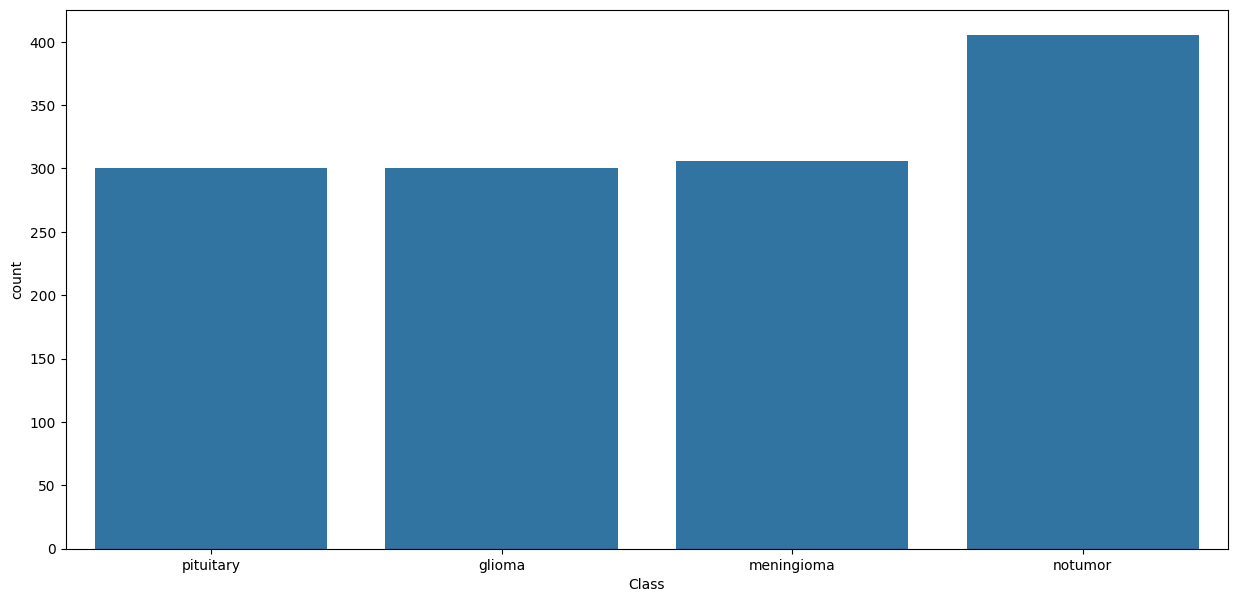

In [37]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df, x=ts_df["Class"])

#3. Divide the dataset

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
#for DL and computer vision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df["Class"])
#stratify: ensure that the data is split in the same proportion for each class

In [40]:
valid_df

,Class Path,Class
501,/content/Testing/glioma/Te-gl_0134.jpg,glioma
866,/content/Testing/meningioma/Te-me_0111.jpg,meningioma
107,/content/Testing/pituitary/Te-piTr_0008.jpg,pituitary
34,/content/Testing/pituitary/Te-pi_0273.jpg,pituitary
445,/content/Testing/glioma/Te-gl_0192.jpg,glioma
...,...,...
435,/content/Testing/glioma/Te-gl_0160.jpg,glioma
1009,/content/Testing/notumor/Te-no_0169.jpg,notumor
1168,/content/Testing/notumor/Te-no_0327.jpg,notumor
1281,/content/Testing/notumor/Te-no_0311.jpg,notumor


In [41]:
ts_df

,Class Path,Class
638,/content/Testing/meningioma/Te-me_0177.jpg,meningioma
136,/content/Testing/pituitary/Te-pi_0252.jpg,pituitary
356,/content/Testing/glioma/Te-gl_0050.jpg,glioma
298,/content/Testing/pituitary/Te-pi_0124.jpg,pituitary
212,/content/Testing/pituitary/Te-pi_0189.jpg,pituitary
...,...,...
730,/content/Testing/meningioma/Te-me_0236.jpg,meningioma
733,/content/Testing/meningioma/Te-me_0110.jpg,meningioma
1260,/content/Testing/notumor/Te-no_0089.jpg,notumor
833,/content/Testing/meningioma/Te-meTr_0009.jpg,meningioma


#4. Pre process the data

In [42]:
#Set parameters

#1. Batch size: numbers of image that the model will process at once

batch_size = 32 #24,16, ..

#2. Resize images, there are different sizes which can cause issues when training the model,
#   by resizing to the same image we can assure the same dimention

img_size = (299,299)

#3. Image data generate: allows to pre process the images by resscalinf the pizel values and adjusting their brightness

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [43]:
#create flow of images from the data frame
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col='Class Path',
                                             y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col='Class Path',
                                             y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                             y_col='Class', batch_size=16, target_size=img_size, shuffle= False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


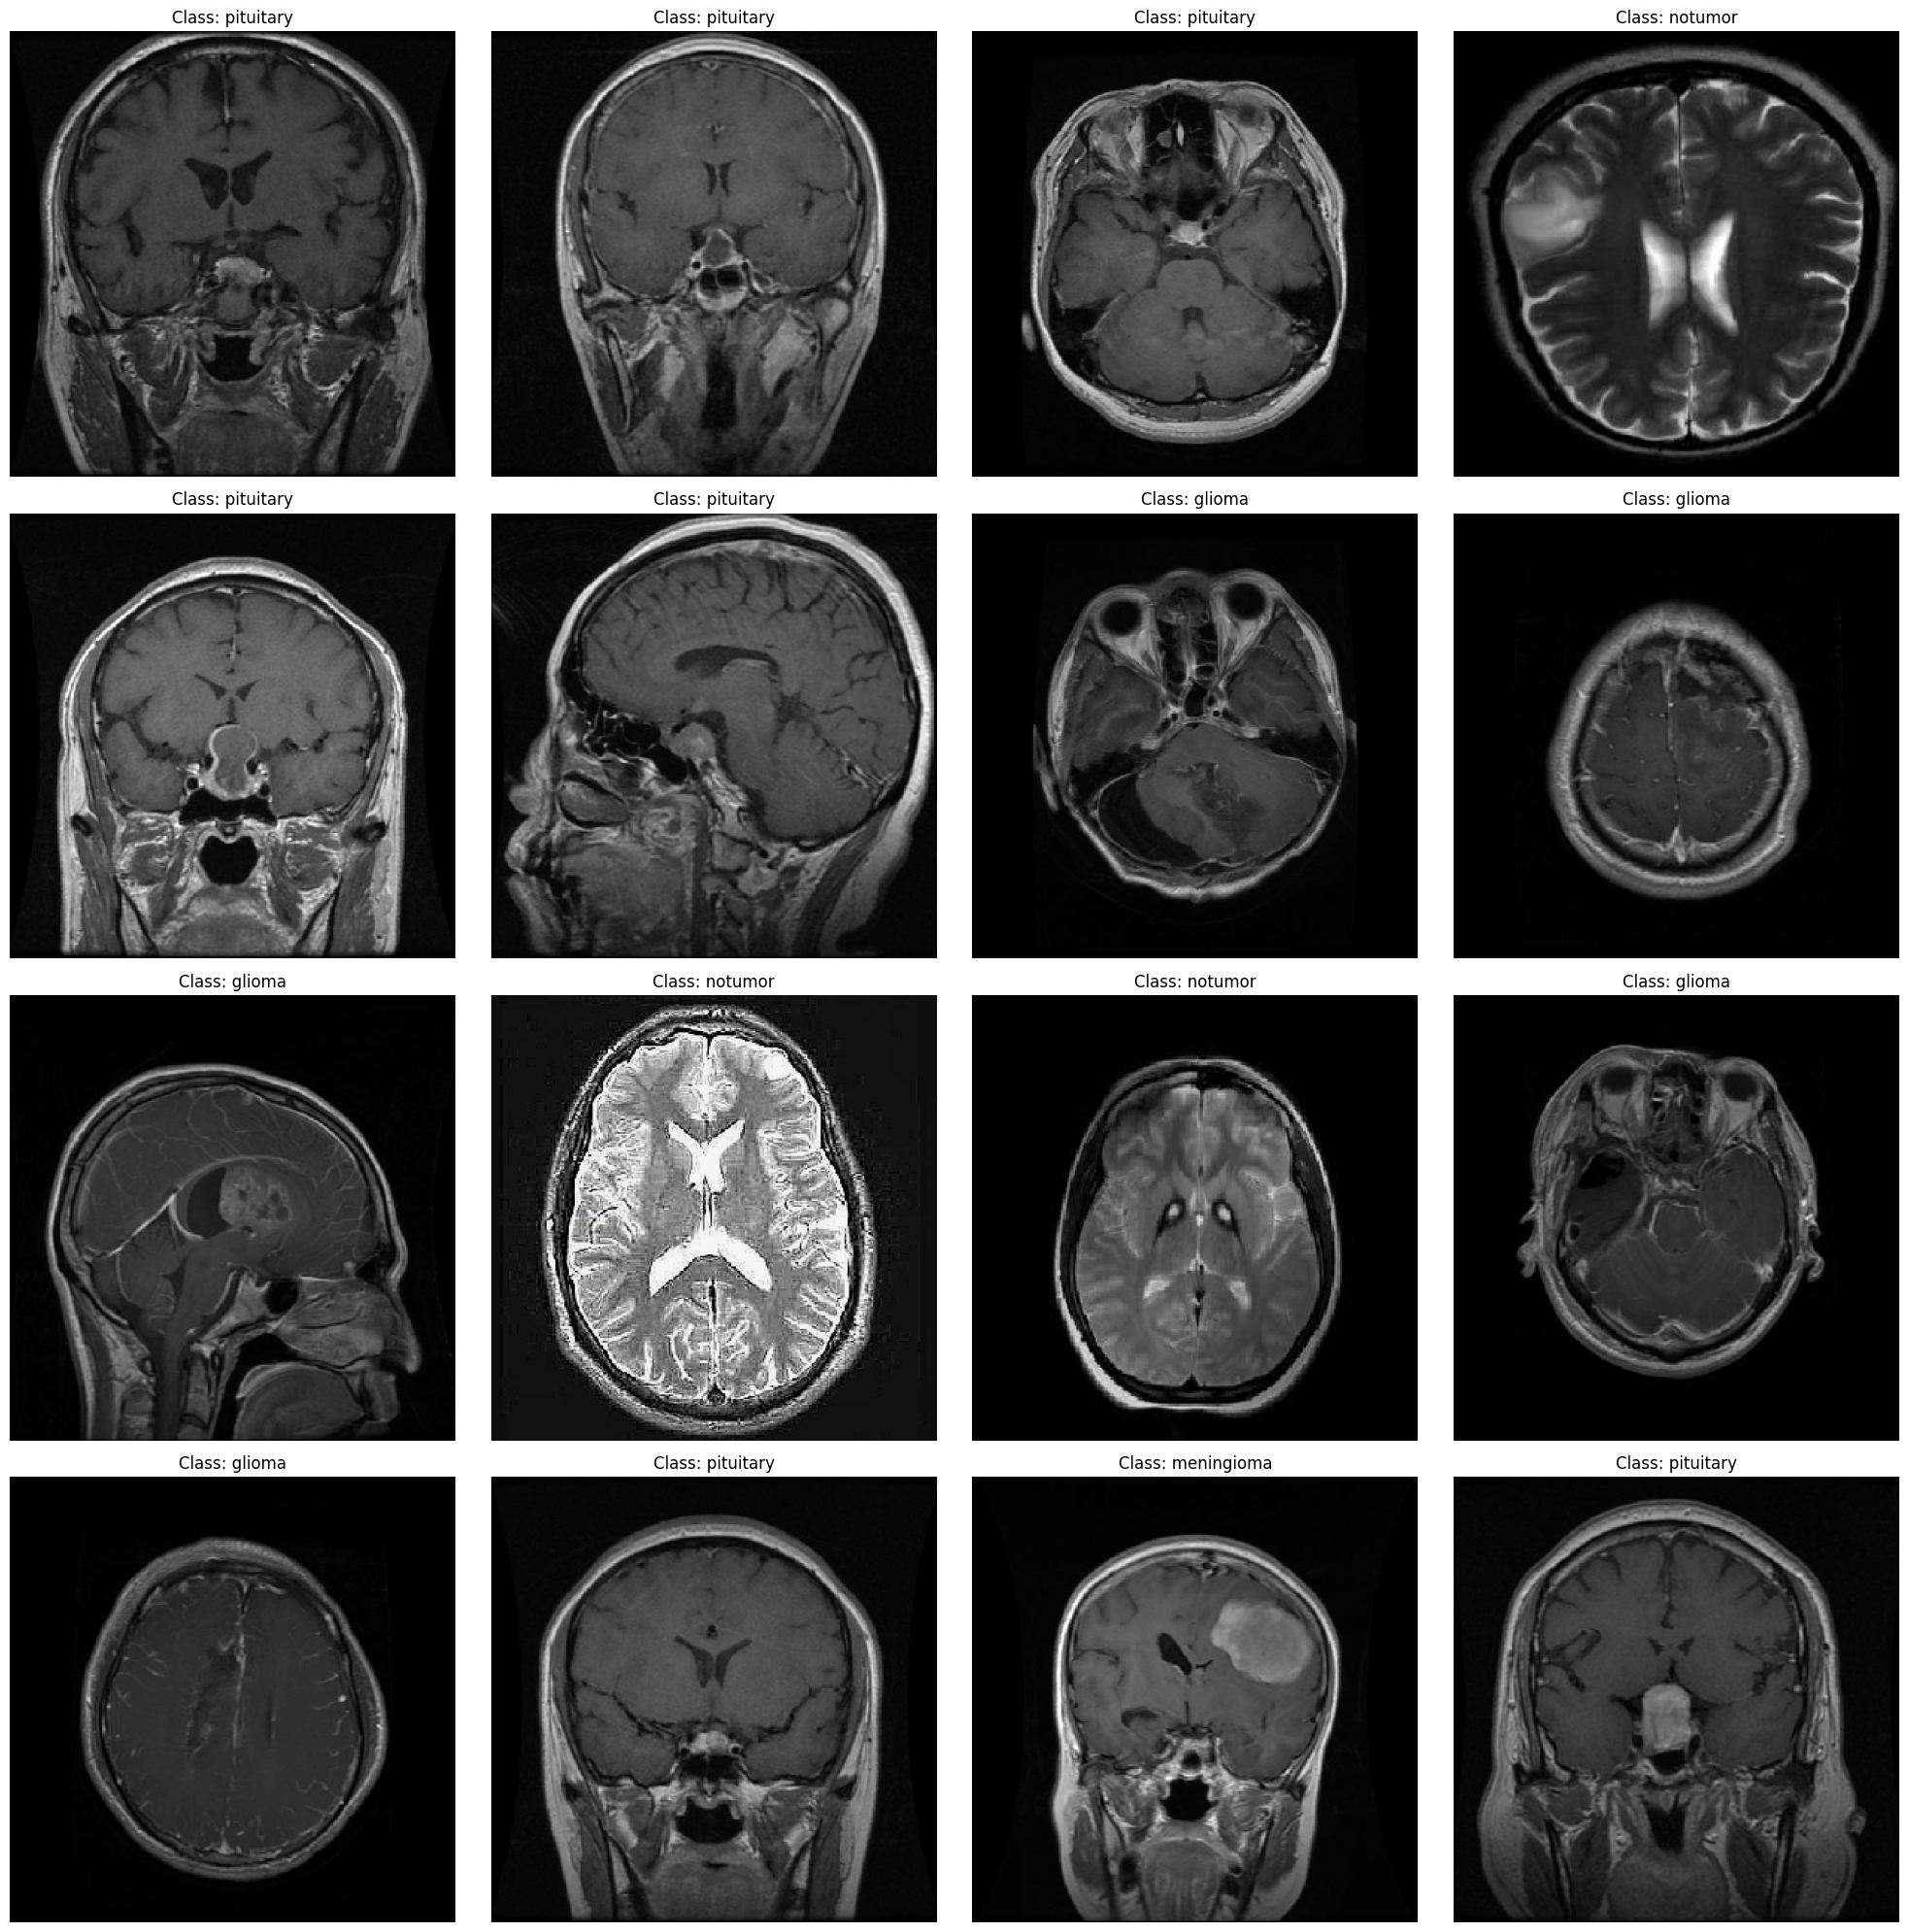

In [44]:
plt.figure(figsize=(20,20))

for i in range(16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  #Get the class index
  class_index = np.argmax(label)

  #Get the list of class names and class indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  #Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  #Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis("off")

plt.tight_layout()
plt.show()

#5. Implement Xception model

In [ ]:
img_shape=(299,299,3)

#include_top= False -> bc we are using the model for transfer learning

base_model = tf.keras.applications.Xception(include_top = False, weights="imagenet",
                                            input_shape = img_shape, pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3), # to prevent overfitten, frop some neurons to help the model generalize
    Dense(128, activation='relu'),#function that help the model lean no lineal
    Dropout(rate = 0.25),
    Dense(4, activation='softmax')#commonly use in classification tasks, typically the same number of classes
                                  # takes the output and transfor it to a probaility distribution over the classes
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Optimizer  that help the model learn by adjusting how the big steps it takes
#it takes when its updating its knowledge anthe weights of the model

#try to find the lowest loss given the loss funtion, minimaze

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',#commonly use in class tasks, measure of how much the preicted model differ from the actual prob
              metrics=['accuracy', Precision(), Recall()])

#6. Train the model

In [ ]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.6540 - loss: 0.8831 - precision: 0.7841 - recall: 0.5092

KeyboardInterrupt: 

In [ ]:
#Get training and validation metrics from history

metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

#Find best epochs and values

best_epochs = {}
best_values = {}

for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

#Plot metrics
plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics,1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric])+1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


#7.Evaluating the models

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)#help how the model learn
valid_score = model.evaluate(valid_gen, verbose=1) # helps understand if there is overffiting
test_score = model.evaluate(ts_gen, verbose=1) #important -> realistic picture of the model perform

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

#Then create and display the confusion matrix

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#8. Testing model

In [ ]:
from PIL import Image

In [ ]:
def predict(img_path: str) -> None:
  #Get class labels
  labels=list(class_dict.keys())

  #Create figure
  plt.figure(figsize=(6,8))

  #Load and preprocess image
  img = Image.open(img_path)
  resized_img=img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array=np.expand_dims(img_array, axis=0)/255.0

  #Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  #Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  #Plot original image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRE Image\nPredicted:{predicted_class}")

  #Plot prediction probabilities
  plt.subplot(2,1,2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class probabilities")

  #Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt="%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\Predicted tumor type: {predicted_class}")

In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

In [ ]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

#9. Implementing CNN model

In [45]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [46]:
batch_size = 16 #fewer images process simulataneusly

img_size = (224,224)


image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df, x_col='Class Path',
                                             y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col='Class Path',
                                             y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                             y_col='Class', batch_size=16, target_size=img_size, shuffle= False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [47]:
#create a Sequential model
cnn_model=Sequential()

#each block qith different number of convolutional filters(extract features)
#1
cnn_model.add(Conv2D(512, (3,3), padding='same', input_shape=(224,224,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))#reduces spatial dimensions, allow focusinf on the most important feature, reduce overfitting
#2
cnn_model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))#random, turns off some conections to reduce overfitting
#3
cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))
#4
cnn_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten the output for fully connected layers
cnn_model.add(Flatten())

#Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax')) #Output layer with 4 neurons for the 4 classes

#Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

#Display the model summary
cnn_model.summary()

#some best practices: umber of laers is factor of 2, going deep -> decrease or increase


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = cnn_model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 35/357 ━━━━━━━━━━━━━━━━━━━━ 3:15:22 36s/step - accuracy: 0.3299 - loss: 4.5107 - precision: 0.3350 - recall: 0.0461

KeyboardInterrupt: 

In [ ]:
history.history.keys()

In [ ]:
#Get training and validation metrics from history

metrics = ['accuracy', 'loss', 'precision_5', 'recall_5']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

#Find best epochs and values

best_epochs = {}
best_values = {}

for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

#Plot metrics
plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics,1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric])+1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


In [ ]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)#help how the model learn
valid_score = cnn_model.evaluate(valid_gen, verbose=1) # helps understand if there is overffiting
test_score = cnn_model.evaluate(ts_gen, verbose=1) #important -> realistic picture of the model perform

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

In [ ]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

#Then create and display the confusion matrix

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

In [ ]:
cnn_model.save("cnn_model.h5")

#Part 2 : Streamlit WEB APP

In [68]:
!apt-get install -y wkhtmltopdf
!pip install pdfkit


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon bind9-host bind9-libs geoclue-2.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas iio-sensor-proxy libavahi-core7 libavahi-glib1
  libdaemon0 libevdev2 libfontenc1 libgudev-1.0-0 libhyphen0 libinput-bin libinput10
  libjson-glib-1.0-0 libjson-glib-1.0-common liblmdb0 libmaxminddb0 libmbim-glib4 libmbim-proxy
  libmd4c0 libmm-glib0 libmtdev1 libnl-genl-3-200 libnotify4 libnss-mdns libproxy1v5 libqmi-glib5
  libqmi-proxy libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5positioning5
  libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5quick5 libqt5sensors5 libqt5svg5
  libqt5webchannel5 libqt5webkit5 libqt5widgets5 libsoup2.4-1 libsoup2.4-common libudev1
  libwacom-bin libwacom-common libwacom9 libwoff1 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libx

In [49]:
!pip install streamlit pyngrok python-dotenv

In [51]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [52]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

Streamlit debe ejecutarse como un proceso externo. Aquí se utiliza os.system para lanzar el comando que inicia la aplicación Streamlit desde la ubicación donde se guardó el archivo

In [53]:
#function to run de app
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [112]:
%%writefile app.py
#allows to save the file

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from google.colab import userdata
from dotenv import load_dotenv
import pdfkit, os

load_dotenv()

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def chat_response(img_path, model_prediction, confidence, user_input):
  prompt = f"""
  You are an expert neurologist, and you are providing feedback to a patient about their results.
  Based on the predicted tumor type ({model_prediction}) with a confidence of {confidence * 100}%,
  kindly answer the following question posed by the patient: '{user_input}'.

  In your response:
  - Use a friendly, reassuring tone suitable for a patient.
  - Keep your explanation concise, no more than 3 sentences.
  - Mention that if the patient has further questions or concerns, they should consult a specialist for a more detailed analysis.

  Your goal is to explain the result clearly and provide comfort to the patient.
  """

  img = PIL.Image.open(img_path)

  # Assuming `genai.GenerativeModel` is used for generating the response from the model
  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  return response.text


def generate_report_tumor_classification(model_prediction, confidence):
  #TODO:make more effective
  prompt = f"""Generate a detailed explanation of the predicted tumor type ({model_prediction}),
  focusing on the medical significance of the prediction, without patient-specific information. Describe the characteristics of this tumor type,
  including its typical features, behavior, and potential risks. Explain the diagnostic and treatment
  relevance of this prediction, without referring to any specific patient data.
  Cofidence of the model: {confidence * 100}%

  In your response:
  - Explain possible reasons why the model made the prediction it did.
  -Keep your explanation to a 6 sentences max.

  Let's think step by step about this. Verify step by step
  """

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt])

  return response.text

def generate_report_map(img_path, model_prediction, confidence):
  #TODO:make more effective
  prompt = f"""Provide an analysis of the saliency map generated by the deep learning model.
  Highlight the key regions identified by the model in the image and explain how these regions
  contributed to the tumor classification. Discuss how the highlighted features, such as shape,
  size, or location, are relevant to the model's prediction and the classification of the tumor type.
  Ensure that the analysis focuses only on the model’s interpretation of the image, without patient-specific information.
  The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

  In your response:
  - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the regions highlighted
  in the light cyan, those are the regions where the model is focusing on.
  - Explain possible reasons why the model made the prediction it did.
  - Don't mention aything like 'The saliency map highlights the regions the model is focusing on, which are in light cyan'
  in your explanation.
  -Keep your explanation to a 8 sentences max.

  Let's think step by step about this. Verify step by step
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  return response.text


def generate_report_next_steps(img_path, model_prediction, confidence):
  #TODO:make more effective
  prompt = f"""Based on the predicted tumor type ({model_prediction}), suggest potential
  follow-up actions for further analysis or clinical evaluation. This could include general
  recommendations for additional diagnostic tests or types of clinical consultations that might be
  relevant to the classification. Focus on next steps related to the tumor type prediction, without
  including any patient-specific treatment or follow-up details.


  In your response:
  -Keep your explanation to a 6 sentences max.


  Let's think step by step about this. Verify step by step
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  return response.text


def generate_explanation(img_path, model_prediction, confidence):
  prompt = f"""You are an expert neurologist. You are tasked with explaining a saliency map of a brain tumor MRI scan.
  The saliency map was generated by a deep learning model that was trained to classify brain tumors
  as either glioma, meningioma, pituitary, or no tumor.

  The saliency map highlights the regions of the image that the machine learning model is focusing on to make the prediction.

  The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence * 100}%.

  In your response:
  - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the regions highlighted
  in the light cyan, those are the regions where the model is focusing on.
  - Explain possible reasons why the model made the prediction it did.
  - Don't mention aything like 'The saliency map highlights the regions the model is focusing on, which are in light cyan'
  in your explanation.
  -Keep your explanation to a 4 sentences max.

  Let's think step by step about this. Verify step by step
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  return response.text

def generate_saliency_map(model, img_array, class_index, img_size):
  with tf.GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    target_class = predictions[:, class_index]

  #calculate gradients to see which part of the input image has the most impact on the prediction
  gradients = tape.gradient(target_class, img_tensor)
  gradients = tf.math.abs(gradients)
  gradients = tf.reduce_max(gradients, axis=-1)
  gradients = gradients.numpy().squeeze()

  #Resize gradients to match original image size
  gradients = cv2.resize(gradients, img_size)

  center = (gradients.shape[0] // 2, gradients.shape[1] //2)
  radius = min(center[0], center[1]) - 10
  y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
  mask = (x - center[0])**2 + (y - center[1])**2 <= radius **2

  #apply mask to gradients
  gradients = gradients * mask

  #Normalize only the brain area
  brain_gradients = gradients[mask]
  if brain_gradients.max() > brain_gradients.min():
    brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
  gradients[mask] = brain_gradients

  #apply a higher threshold
  threshold = np.percentile(gradients[mask], 80)
  gradients[gradients < threshold] = 0

  gradients = cv2.GaussianBlur(gradients, (11,11), 0)

  #Create a heatmap overlay enhanced contrast
  heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  #Resize heatmap to match original image size
  heatmap = cv2.resize(heatmap, img_size)

  #Superimpose the heatmap on original image with increase opacity
  original_img = image.img_to_array(img)
  superimposed_img = heatmap * 0.7 + original_img * 0.3
  superimposed_img = superimposed_img.astype(np.uint8)

  img_path = os.path.join(output_dir, uploaded_file.name)
  with open(img_path, "wb") as f:
    f.write(uploaded_file.getbuffer())

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'

  #Save the saliency map
  cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

  return superimposed_img


def load_xception_model(model_path):
  img_shape=(299,299,3)
  base_model = tf.keras.applications.Xception(include_top=False,
                                              weights="imagenet",
                                              input_shape=img_shape, pooling="max")
  model = Sequential([base_model,
                      Flatten(), Dropout(rate=0.3),Dense(128, activation='relu'),
                      Dropout(rate=0.25), Dense(4, activation='softmax')])

  model.build((None,)+img_shape)

  #Compile the model
  model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

  model.load_weights(model_path)

  return model

st.title("Brain Tumor Classification")

st.write("Upload an image of a brain MRI scan to classify")

uploaded_file =st.file_uploader("Choose an image...", type=["jpg","jpeg","png"])

if uploaded_file is not None:

  selected_model = st.radio(
      "Select Model",
      ("Transfer Learning - Xception", "Custom CNN")
  )

  if selected_model =="Transfer Learning - Xception":
    model = load_xception_model('/content/xception_model.weights.h5')
    img_size = (299,299)
  else:
    model = load_model('/content/cnn_model.h5')
    img_size = (224,224)

  labels =['Glioma', 'Meningioma', 'No tumor', 'Pitutiary']
  img = image.load_img(uploaded_file, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)

  #Get the class with the highest probability

  class_index = np.argmax(prediction[0])
  result = labels[class_index]

  saliency_map = generate_saliency_map(model, img_array, class_index, img_size)

  col1, col2 = st.columns(2)
  with col1:
    st.image(uploaded_file, caption='Upload image',  use_container_width = True)
  with col2:
    st.image(saliency_map, caption='Saliency Map ',  use_container_width = True)


  st.write("## Clasification Results")

  result_container = st.container()
  #different charts
  result_container.markdown(
      f"""
      <div style="background-color: #000000; color: #ffffff; padding: 30px; border-radius:15px;">
        <div style="display: flex; justify-content: space-between; align-items: center;">
          <div style="flex: 1; text-align:center;">
            <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Prediction</h3>
            <p style="font-size: 36px; font-weight: 800; color: #FF0000; margin: 0">
              {result}
            </p>
          </div>
          <div style="width: 2px; height: 80px; background-color: #ffffff; margin: 0 20px;"></div>
          <div style="flex:1; text-align:center;">
            <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px:">Confidence</h3>
            <p style="font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;">
              {prediction[0][class_index]:.4%}
            </p>
          </div>
        </div>
      </div>

      """,
      unsafe_allow_html=True
  )

  probabilities = prediction[0]
  sorted_indices = np.argsort(probabilities)[::-1]
  sorted_labels = [labels[i] for i in sorted_indices]
  sorted_probabilities = probabilities[sorted_indices]

  fig = go.Figure(go.Bar(
      x=sorted_probabilities,
      y=sorted_labels,
      orientation='h',
      marker_color=['red' if label == result else 'blue' for label in sorted_labels]
  ))

  fig.update_layout(
      title='Probabilities for each class',
      xaxis_title='Probability',
      yaxis_title='Class',
      height=400,
      width=600,
      yaxis=dict(autorange="reversed")
  )

  for i, prob in enumerate(sorted_probabilities):
    fig.add_annotation(
        x=prob,
        y=i,
        text=f'{prob:.4f}',
        showarrow=False,
        xanchor='left',
        xshift=5
    )

  st.plotly_chart(fig)

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'
  explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])
  report_1 = generate_report_tumor_classification(result, prediction[0][class_index])
  report_2 = generate_report_map(saliency_map_path, result, prediction[0][class_index])
  report_3 = generate_report_next_steps(saliency_map_path, result, prediction[0][class_index])
  st.write("## Explanation")
  st.write(explanation)

  report_html = f"""
  <div>
    <h1>Medical Report</h1>
    <h3>General Explanation</h3>
    {explanation}
    <h3>Tumor Classification</h3>
    <p>{report_1}</p>
    <h3>Saliency Map Analysis</h3>
    <p>{report_2}</p>
    <h3>Next Steps</h3>
    <p>{report_3}</p>
  </div>
  """
  st.write("## Chat with an AI Specialist")
  user_input = st.text_input("Ask about tumor classification or saliency map:")

  if user_input:
    respuesta = chat_response(saliency_map_path, result, prediction[0][class_index], user_input)

    st.markdown(f"""
    <div style="background-color:#000000; padding: 10px; border-radius: 10px; margin-bottom: 10px;">
        <b style="color: yellow;">User:</b> <span style="color: yellow;">{user_input}</span>
    </div>
    <div style="background-color:#000000; padding: 10px; border-radius: 10px; margin-bottom: 10px;">
        <b style="color: white;">AI Specialist:</b> <span style="color: white;">{respuesta}</span>
    </div>
    """, unsafe_allow_html=True)

  st.write("## Generate a report")
  file_name = 'report.pdf'
  pdfkit.from_string(report_html, file_name)
  with open(file_name, "rb") as pdf_file:
      st.download_button(
          'Download PDF',
          data = pdf_file,
          file_name = file_name,
          mime = 'application/octet-stream')
      os.remove(file_name)




Overwriting app.py


En Colab, el proceso que ejecuta el código de las celdas es el mismo que administra el entorno de Jupyter. Si ejecutas Streamlit directamente en ese proceso, bloquearía el notebook, haciéndolo inutilizable. Para evitarlo, se lanza Streamlit en un hilo paralelo, permitiendo que el notebook siga funcionando.

In [113]:
thread = Thread(target=run_streamlit)
thread.start()

In [72]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://7cd6-34-29-141-91.ngrok-free.app" -> "http://localhost:8501"


In [71]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://48d5-34-29-141-91.ngrok-free.app -> http://localhost:8501
